# Techniques to Improve Image Classification CNNs

There are several techniques known to improve the accuracy, training efficiency, and generalization capability of convolutional neural networks (CNNs) for image classification. These techniques span across **data preprocessing and augmentation**, **model architecture**, **optimization and regularization**, **training strategy**, and **evaluation**. Below is a comprehensive list:

## 1. Data Preprocessing and Augmentation

- **Image Rescaling and Normalization**: Rescale pixel values to a range like \([0, 1]\) or standardize to zero mean and unit variance, which helps models converge faster.
- **Data Augmentation**: Generate variations of images to improve generalization:
  - **Random Cropping**
  - **Random Flipping** (horizontal, vertical)
  - **Color Jittering** (brightness, contrast, saturation)
  - **Rotation** and **Scaling**
  - **Random Zoom** and **Random Translation**
  - **Gaussian Noise**: Adds noise to images to make the model robust to variations.
  - **Mixup and CutMix**: Mixes two images or crops a portion of one image and places it in another, creating synthetic blended samples.
- **Use of Generative Models**: Use GANs or VAEs to generate additional training samples for minority classes or to increase dataset diversity.

## 2. Model Architecture Improvements

- **Batch Normalization**: Helps stabilize and accelerate training by normalizing activations within each mini-batch.
- **Residual Connections**: Use skip connections (as in ResNet) to help train deeper networks by alleviating the vanishing gradient problem.
- **Attention Mechanisms**: Channel and spatial attention layers (e.g., SE blocks, CBAM) to allow the network to focus on important parts of the image.
- **Depthwise Separable Convolutions**: Decompose convolutions into depthwise and pointwise convolutions to reduce model parameters while maintaining performance (used in MobileNet).
- **Inception Modules**: Multi-scale processing by combining different kernel sizes within the same layer, as seen in GoogLeNet.
- **Dilated/Atrous Convolutions**: Increase the receptive field without increasing the number of parameters, useful in segmentation and dense classification.
- **Transformer Blocks**: Add attention-based transformer blocks for better global context, as in vision transformers (ViT).

## 3. Optimization Techniques

- **Adaptive Optimizers**: Use optimizers like **Adam**, **RMSprop**, or **AdamW** for faster convergence than traditional **SGD**.
- **Learning Rate Scheduling**:
  - **Step Decay**: Reduces the learning rate at fixed intervals.
  - **Exponential Decay**: Reduces the learning rate continuously based on an exponential function.
  - **Cosine Annealing**: Gradually reduces the learning rate following a cosine curve.
  - **Warmup and Cosine Decay**: Starts with a lower learning rate and gradually warms up, then applies cosine decay.
  - **Cyclical Learning Rates**: Varies the learning rate within a range, helping the model escape local minima.
- **Gradient Clipping**: Limits the gradient magnitude to prevent exploding gradients in RNNs or very deep networks.

## 4. Regularization Techniques

- **Dropout**: Randomly turns off a fraction of neurons in each layer during training to prevent overfitting.
- **L2 and L1 Regularization**: Adds penalties to the loss function to reduce model complexity and prevent overfitting.
- **Label Smoothing**: Reduces confidence in the labels to make the model more robust.
- **Early Stopping**: Stops training when the validation loss stops improving to prevent overfitting.
- **Stochastic Weight Averaging (SWA)**: Averages weights over the last few epochs to improve generalization.

## 5. Training Strategies

- **Transfer Learning**: Use pre-trained models (e.g., ResNet, VGG) and fine-tune on a specific dataset to achieve higher accuracy with less data.
- **Fine-Tuning**: Unfreeze top layers of a pre-trained model and retrain on the new dataset, adapting it to specific classes.
- **Self-Supervised Learning**: Pretrain the model on unlabeled data, allowing it to learn useful features without labeled data.
- **Curriculum Learning**: Start training on simpler tasks or easier samples, and gradually increase difficulty.
- **Multi-Task Learning**: Train the model on related tasks simultaneously (e.g., classification and segmentation).
- **Semi-Supervised Learning**: Use labeled and unlabeled data (e.g., with pseudo-labeling or consistency regularization).
- **Active Learning**: Selectively label samples that the model is uncertain about to make training more data-efficient.

## 6. Evaluation and Monitoring Techniques

- **K-Fold Cross-Validation**: Use cross-validation to better estimate model performance and avoid overfitting.
- **Ensembling Models**: Combine multiple models to reduce variance and improve accuracy (e.g., majority voting, averaging predictions).
- **Model Checkpointing**: Save the best model during training to avoid loss of progress due to poor final epochs.
- **Hyperparameter Tuning**: Use grid search or random search to find optimal hyperparameters.
- **Monitoring with Validation Data**: Monitor validation loss and accuracy to detect overfitting or underfitting early on.

## 7. Advanced Techniques

- **Knowledge Distillation**: Train a smaller “student” model to mimic a larger “teacher” model’s outputs, achieving higher accuracy with a smaller model.
- **Neural Architecture Search (NAS)**: Automates the search for optimal model architecture (e.g., EfficientNet).
- **AutoAugment and RandAugment**: Automatically search for the best data augmentation policies.
- **Learning Rate Finder**: Empirically find an optimal starting learning rate for faster convergence.

Each of these techniques can be tailored to the dataset and model architecture to boost performance effectively. Using combinations of these methods, such as pre-trained models, data augmentation, dropout, learning rate scheduling, and hyperparameter tuning, is common in high-performing image classification models.


# Recommendations for Building an Image Classification Model

Building a robust model for image classification involves various considerations and strategies. Here’s a comprehensive list of recommendations tailored for your dataset of 5,004 images:

## 1. Data Preprocessing
- **Normalization:** Scale pixel values to the range [0, 1] by dividing by 255.
- **Resizing:** Ensure all images are resized to a consistent size (e.g., 96x96) to match your model's input requirements.
- **Augmentation:** Implement data augmentation (random flips, rotations, shifts, brightness adjustments, etc.) to increase dataset variability and prevent overfitting.

## 2. Dataset Split
- **Training, Validation, Test Split:** Split your dataset into training (e.g., 70%), validation (e.g., 15%), and test (e.g., 15%) sets to evaluate model performance and generalization.
- **Stratification:** If you have multiple classes, ensure that your split maintains the class distribution.

## 3. Model Architecture
- **Convolutional Layers:** Start with a stack of convolutional layers to extract features. Use ReLU activation for non-linearity.
- **Pooling Layers:** Use MaxPooling layers to reduce spatial dimensions and retain important features.
- **Dropout:** Incorporate Dropout layers to prevent overfitting, especially in dense layers.
- **Dense Layers:** Add fully connected layers at the end, with the final layer having a softmax activation for multi-class classification.
- **Batch Normalization:** Use Batch Normalization to stabilize training and improve convergence speed.

## 4. Regularization Techniques
- **Early Stopping:** Implement early stopping to halt training when validation performance starts to degrade.
- **L2 Regularization:** Add L2 regularization in dense layers to reduce overfitting.
- **Data Augmentation:** Continue augmenting data during training to expose the model to diverse examples.

## 5. Optimization Strategy
- **Learning Rate:** Use a learning rate scheduler to adjust the learning rate during training, or use adaptive optimizers like Adam or RMSprop.
- **Loss Function:** Choose the appropriate loss function, such as categorical crossentropy for multi-class classification.
- **Batch Size:** Experiment with different batch sizes (e.g., 32, 64) to find the best for your dataset.

## 6. Evaluation Metrics
- **Validation Metrics:** Track validation accuracy and loss to monitor model performance during training.
- **Confusion Matrix:** Use a confusion matrix to evaluate class-specific performance and identify misclassifications.

## 7. Model Experimentation
- **Hyperparameter Tuning:** Experiment with various hyperparameters, including the number of layers, number of filters, kernel sizes, and dropout rates.
- **Cross-Validation:** If feasible, consider k-fold cross-validation to ensure your model is robust and generalizes well across different splits of the data.

## 8. Post-Training Evaluation
- **Test Set Evaluation:** After training, evaluate the model on the test set to assess its performance on unseen data.
- **Model Interpretation:** Consider using techniques such as Grad-CAM to visualize and interpret model predictions.

## 9. Deployment Considerations
- **Model Size:** Optimize your model for size if deploying on limited-resource environments (e.g., mobile devices).
- **Inference Speed:** Ensure the model inference speed is acceptable for your application.

## 10. Documentation and Versioning
- **Document Experiments:** Keep track of different experiments, hyperparameters, and results for reproducibility and comparison.
- **Model Versioning:** If using a framework like MLflow or DVC, consider versioning your models for better management.

By following these recommendations, you can systematically build, evaluate, and refine your image classification model, potentially achieving better performance and generalization on your dataset.


In [22]:
USE_COLAB = False
PRINT_OUTLIERS = False
SHOW_MODEL_SUMMARY = True
BATCH_SIZE = 32
EPOCHS = 1000
LEARNING_RATE = 1e-4
AUGMENTATION = True
CONV_LAYERS = 3
DENSE_LAYERS = 2
NODES_PER_LAYER = 1024
DROPOUT_RATE = 0.3
PATIENCE = 100
L2_REGULARIZATION = 0.1
USE_BASE_MODEL = False
USE_BATCH_NORMALIZATION = True
USE_CLASS_WEIGHTS = True
SEED = 72121

In [23]:
if USE_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    %cd /gdrive/My Drive/ANN/CHAL1

In [24]:
from libraries import *
from preprocess import *

Unique labels in the dataset: [0 1 2 3 4 5 6 7]
Class 0: 1052 images
Class 1: 2381 images
Class 2: 1285 images
Class 3: 2226 images
Class 4: 1049 images
Class 5: 1393 images
Class 6: 2530 images
Class 7: 1843 images


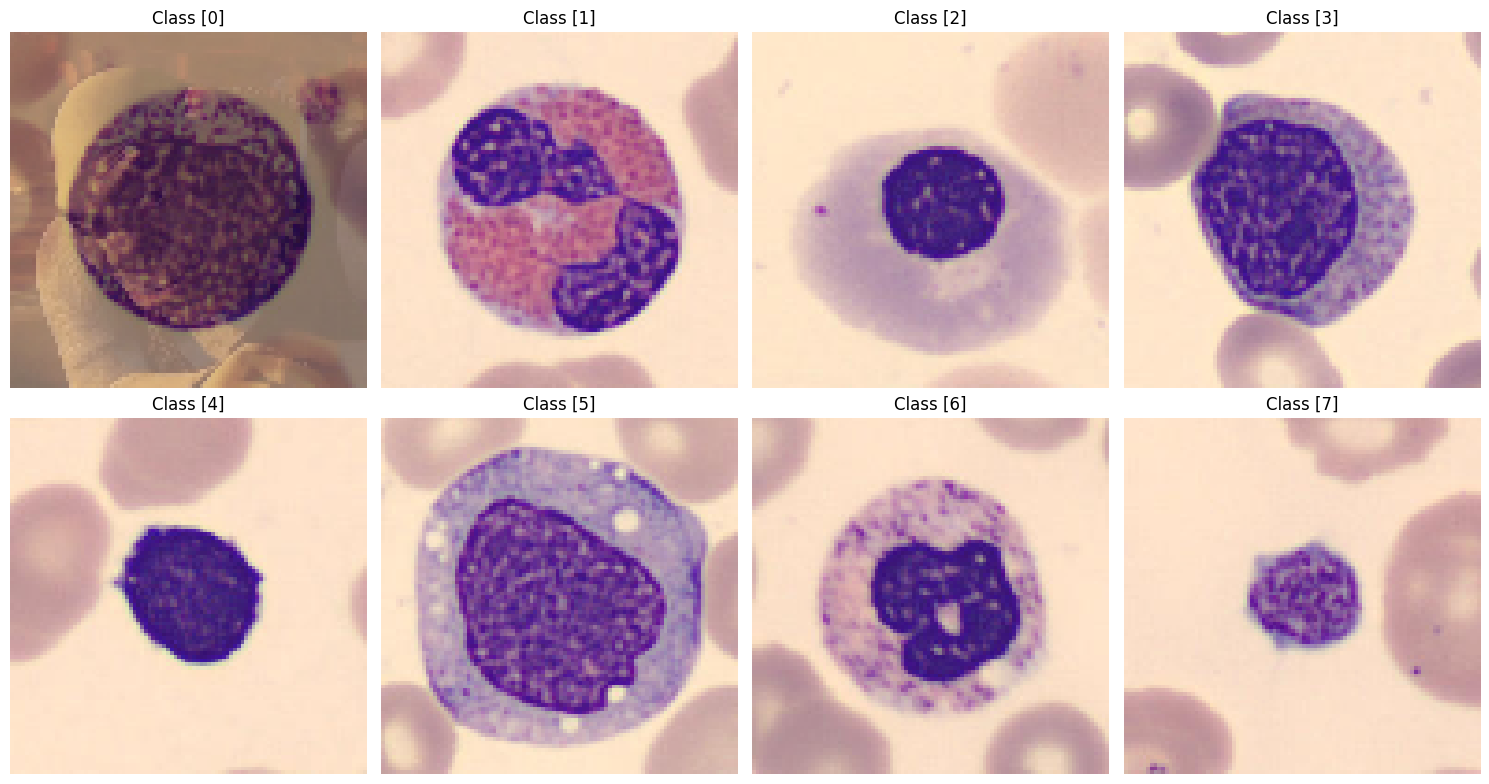

In [25]:
# Load data
data = np.load('data/training_set.npz', allow_pickle=True)

# Divide data
labels = data['labels']
images = data['images']

# Print unique labels and their counts
unique_labels = np.unique(labels)
print("Unique labels in the dataset:", unique_labels)
for label in unique_labels:
    count = np.sum(labels == label)
    print(f"Class {label}: {count} images")

# Create a dictionary to store indices for each class
class_indices = {label: np.where(labels == label)[0] for label in unique_labels}

# Select one random image per class
selected_indices = [np.random.choice(class_indices[label]) for label in unique_labels]

# Plot one image per class
num_classes = len(unique_labels)
num_cols = 4  # You can adjust this for layout
num_rows = (num_classes + num_cols - 1) // num_cols

plt.figure(figsize=(15, 4 * num_rows))
for i, idx in enumerate(selected_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(np.clip(images[idx] / 255.0, 0, 1))
    plt.title(f"Class {labels[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [26]:
images, labels = clean_dataset(images, labels)
images, labels = balance_classes(images, labels, target_class_size=np.mean(np.bincount(labels)))

In [6]:
# split data 
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=SEED, stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEED, stratify=y_train_val)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}\n")

def print_class_distribution(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    percentages = counts / counts.sum() * 100
    print(f"{set_name} set:")
    for cls, percentage in zip(unique, percentages):
        print(f"Class {cls}: {percentage:.2f}%")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")



Train size: 10074
Validation size: 2519
Test size: 3149

Train set:
Class 0: 10.84%
Class 1: 13.86%
Class 2: 13.79%
Class 3: 12.87%
Class 4: 10.78%
Class 5: 12.63%
Class 6: 14.80%
Class 7: 10.43%
Validation set:
Class 0: 10.84%
Class 1: 13.85%
Class 2: 13.78%
Class 3: 12.86%
Class 4: 10.80%
Class 5: 12.62%
Class 6: 14.81%
Class 7: 10.44%
Test set:
Class 0: 10.83%
Class 1: 13.85%
Class 2: 13.78%
Class 3: 12.86%
Class 4: 10.80%
Class 5: 12.64%
Class 6: 14.80%
Class 7: 10.45%


In [7]:
# one hot encoding of labeles
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

# print example
print("Example of one hot encoded labels:")
print(y_train[:5])

Example of one hot encoded labels:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


In [8]:
input_shape = X_train[0].shape

output_shape = y_train[0].shape[0]

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")


Input shape: (96, 96, 3)
Output shape: 8


In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=LEARNING_RATE,
    augmentation=None,
    seed=SEED,
    conv_layers=CONV_LAYERS,
    dense_layers=DENSE_LAYERS,
    dropout_rate=DROPOUT_RATE,
    l2_regularization=L2_REGULARIZATION,
    use_base_model=USE_BASE_MODEL,
    target_size=(224, 224)
):
    tf.random.set_seed(seed)
    
    relu_initialiser = tfk.initializers.HeNormal(seed=seed)
    output_initialiser = tfk.initializers.GlorotNormal(seed=seed)
    regularizer = tfk.regularizers.l2(l2_regularization)
    
    # Define the input layer with original input shape
    input_layer = tfk.Input(shape=input_shape, name='input_layer')
    
    # Add preprocessing layers
    if use_base_model:
        x = tfkl.Resizing(*target_size, interpolation='bicubic')(input_layer)
    x = tfkl.Rescaling(1./255)(x if use_base_model else input_layer)

    
    if use_base_model:
        # Load the base model
        base_model = ResNet50(include_top=False, 
                            input_shape=(target_size[0], target_size[1], 3), 
                            weights='imagenet')
        base_model.trainable = False
        
        # Apply augmentation if specified
        x = augmentation(x) if augmentation else x
        
        x = base_model(x)    
        x = tfkl.GlobalAveragePooling2D(name='avg_pool')(x)
        
    else:
        # Apply augmentation if specified
        x = augmentation(x) if augmentation else x
        
        # Add Conv layers
        x = tfkl.Conv2D(filters=16, kernel_size=3, activation='relu', 
                       padding='same', name='first_conv')(x)
        x = tfkl.MaxPooling2D((2, 2), name='first_maxpool')(x)
        
        for i in range(conv_layers - 1):
            num_filters = 32 * (2 ** i)
            x = tfkl.Conv2D(
                filters=num_filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                name=f'conv_{num_filters}')(x)
            
            if i < conv_layers - 2:  # Apply MaxPooling except for last conv layer
                x = tfkl.MaxPooling2D((2, 2), name=f'maxpool_{num_filters}')(x)
        
        # Apply GlobalAveragePooling2D after all conv layers
        x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Add Dense layers
    for i in range(dense_layers):
        x = tfkl.Dense(int(NODES_PER_LAYER/(2**i)),
                      activation='relu',
                      name=f'dense_{i+1}',
                      kernel_initializer=relu_initialiser)(x)
        
        if USE_BATCH_NORMALIZATION:    
            x = tfkl.BatchNormalization()(x)
            
        if dropout_rate > 0:    
            x = tfkl.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
    
    output_layer = tfkl.Dense(output_shape, 
                             activation='softmax', 
                             name='output_layer', 
                             kernel_initializer=output_initialiser, 
                             kernel_regularizer=regularizer 
                             if l2_regularization > 0 else None)(x)

    # Create model
    model = tfk.Model(input_layer, output_layer)

    # Compile the model
    model.compile(optimizer=tfk.optimizers.Adam(learning_rate=learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [ ]:
if AUGMENTATION:
    augmentation = tfk.Sequential([
        tfkl.RandomFlip('horizontal'),
        tfkl.RandomFlip('vertical'),
        tfkl.RandomRotation(0.3),
        tfkl.RandomContrast(0.2),
        tfkl.RandomTranslation(0.2, 0.2),
        tfkl.RandomBrightness(0.2)
    ], name='augmentation')

In [ ]:
model = build_model(
    augmentation=augmentation if AUGMENTATION else None
)

if SHOW_MODEL_SUMMARY:
    model.summary()

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE,
    restore_best_weights=True,
    mode='auto',
)

callbacks = [early_stopping]


In [ ]:
# Calculate the total number of samples
num_samples = len(labels)

# Initialize a dictionary to count occurrences of each class
class_counts = {cls: 0 for cls in np.unique(labels)}

# Count occurrences of each class
for cls in np.unique(labels):
    class_counts[cls] = len(labels[labels == cls])
    print(f"Class {cls}: {class_counts[cls]} samples")

# Calculate class weights
class_weight = {i: 1 for i in range(8)}  # Default weights set to 1 for each class

if USE_CLASS_WEIGHTS:
    class_weight = {
        i: num_samples / (8 * class_counts[i]) for i in range(8)
    }


print(f"Class weights: {class_weight}")



In [ ]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weight
).history

final_val_acc = history['val_accuracy'][-(PATIENCE+1)] * 100
print(f'Final validation accuracy: {final_val_acc:.0f}')

In [ ]:
# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# save model using val acc
model.save(f'models/model_{final_val_acc:.0f}_{timestamp}.keras')

del model

In [ ]:
# Function to log model parameters to a text file
def log_model_parameters(final_val_acc, timestamp):    
    # Create the log filename with date and time
    log_filename = f'models/model_{final_val_acc:.0f}_params_{timestamp}.txt'
    
    # Write the parameters to the log file
    with open(log_filename, 'w') as log_file:
        log_file.write("Model Training Parameters:\n\n")
        log_file.write(f"BATCH_SIZE: {BATCH_SIZE}\n")
        log_file.write(f"EPOCHS: {EPOCHS}\n")
        log_file.write(f"LEARNING_RATE: {LEARNING_RATE}\n")
        log_file.write(f"AUGMENTATION: {AUGMENTATION}\n")
        log_file.write(f"CONV_LAYERS: {CONV_LAYERS}\n")
        log_file.write(f"DENSE_LAYERS: {DENSE_LAYERS}\n")
        log_file.write(f"NODES_PER_LAYER: {NODES_PER_LAYER}\n")
        log_file.write(f"DROPOUT_RATE: {DROPOUT_RATE}\n")
        log_file.write(f"PATIENCE: {PATIENCE}\n")
        log_file.write(f"L2_REGULARIZATION: {L2_REGULARIZATION}\n")
        log_file.write(f"USE_BASE_MODEL: {USE_BASE_MODEL}\n")
        log_file.write(f"USE_BATCH_NORMALIZATION: {USE_BATCH_NORMALIZATION}\n")
        log_file.write(f"USE_CLASS_WEIGHTS: {USE_CLASS_WEIGHTS}\n")
        

# Log the model parameters
log_model_parameters(final_val_acc, timestamp)


In [ ]:
# plot training loss and accuracy
def plot_training(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(history['loss'], label='train')
    axs[0].plot(history['val_loss'], label='validation')
    axs[0].set_title('Loss')
    axs[0].legend()

    axs[1].plot(history['accuracy'], label='train')
    axs[1].plot(history['val_accuracy'], label='validation')
    axs[1].set_title('Accuracy')
    axs[1].legend()

    plt.show()
    
plot_training(history)



# Make inference

In [ ]:
# Load the saved model
# model = tfk.models.load_model(f'models/model_{final_val_acc:.0f}_{timestamp}.keras')



In [ ]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions_classes)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions_classes, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions_classes, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions_classes, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions_classes)

# Plot the confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=[f'Class {i}' for i in range(8)], 
            yticklabels=[f'Class {i}' for i in range(8)], cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Classification report for detailed metrics per class
print("\nClassification Report:\n")
print(classification_report(test_gt, test_predictions_classes))

# ROC-AUC score for each class (only if this is multilabel or multiclass with probability predictions)
# Binarize the output classes for AUC calculation
y_test_binarized = label_binarize(test_gt, classes=range(8))
roc_auc_scores = []
for i in range(8):
    try:
        roc_auc = roc_auc_score(y_test_binarized[:, i], test_predictions[:, i])
        roc_auc_scores.append(roc_auc)
        print(f"Class {i} ROC-AUC Score: {round(roc_auc, 4)}")
    except ValueError:
        print(f"Class {i} ROC-AUC Score: Unable to calculate (not enough samples).")

# Optional: Display mean ROC-AUC score across classes
if roc_auc_scores:
    print(f"\nMean ROC-AUC Score: {round(np.mean(roc_auc_scores), 4)}")